# Variational autoencoder on an MNIST dataset

## General setup

In [1]:
# import libraries
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [3]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
#train_on_gpu = False
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU.')

Training on GPU!


## Download and create data loaders

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='..\data\\raw', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='..\data\\raw', train=False,
                                  download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

c:\users\aurelijus\appdata\local\programs\python\python38\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Visually check if everything is loaded correctly

<ipython-input-5-731dd270b2c2>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


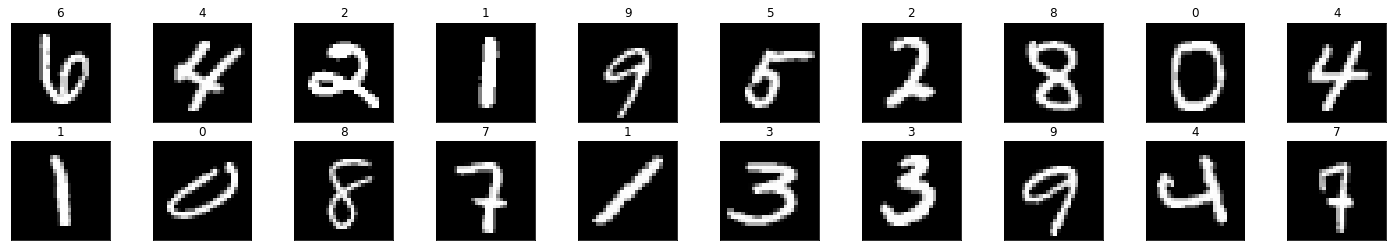

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

## Define the model class

In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # Network architecture
        fc1Size = 512
        fc2Size = 256
        self.hidden_size = 2
        
        #Encoder
        self.fc1 = nn.Linear(28*28, fc1Size)
        self.fc2 = nn.Linear(fc1Size, fc2Size)
        
        #Latent space
        self.hidden2mu = nn.Linear(fc2Size, self.hidden_size)
        self.hidden2log_var = nn.Linear(fc2Size, self.hidden_size)
        
        #Decoder
        self.fc3 = nn.Linear(self.hidden_size, fc2Size)
        self.fc4 = nn.Linear(fc2Size, fc1Size)

        self.fc5 = nn.Linear(fc1Size, 28*28)
        
        #functions
        self.ReLU = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def encoder(self,x):
        x = self.ReLU(self.fc1(x))
        x = self.ReLU(self.fc2(x))
        
        mu, log_var = self.hidden2mu(x), self.hidden2log_var(x)
        return mu, log_var
    
    def reparametrize(self, mu, log_var):
        # Reparametrization Trick to allow gradients to backpropagate from the
        # stochastic part of the model
        sigma = torch.exp(0.5*log_var)
        z = torch.randn_like(sigma)
        return mu + sigma*z
    
    def decoder(self,x):
        x = self.ReLU(self.fc3(x))
        x = self.ReLU(self.fc4(x))
        
        x = self.sigmoid(self.fc5(x))
        x = torch.clamp(x, min=0.0, max=1.0)
        return x

    def forward(self,x):
        batch_size = x.size(0)
        x = x.view(batch_size, 28 * 28)
        
        mu, log_var = self.encoder(x) 
        x = self.reparametrize(mu, log_var)
        x = self.decoder(x)  
        return mu, log_var, x

model = VAE()
if(train_on_gpu):
        model.cuda()
print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (hidden2mu): Linear(in_features=256, out_features=2, bias=True)
  (hidden2log_var): Linear(in_features=256, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=784, bias=True)
  (ReLU): ReLU()
  (sigmoid): Sigmoid()
)


## Define the optimization parameters

note: Binary cross entropy loss works a lot better than mean square error loss in this particular case

In [7]:
# Loss function
#criterion = nn.MSELoss()
criterion = nn.BCELoss(reduction='sum')

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, amsgrad = True)

In [8]:
def loss_function(output, data, mu, log_var, alpha):
    #Reconstruction error + KL-divergence error
    
    # KL-divergence error
    kl_loss = (-0.5*(1+log_var - mu**2 -
        torch.exp(log_var)).sum(dim=1)).mean(dim=0)
    # Reconstruction loss
    recon_loss = criterion(output, data.view(batch_size, 28*28))
    # Total model loss
    loss = recon_loss*alpha + kl_loss
    
    return loss

## Model training cycle

In [9]:
# number of epochs to train the model
n_epochs = 10

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

alpha = 1 #Reconstruction loss multiplier (Higher values prioritise reconstruction loss over KL-divergence error)

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        if(train_on_gpu):
            data = data.cuda()
            
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        mu, log_var, output = model(data)
        #Calculate training loss
        loss = loss_function(output, data, mu, log_var, alpha)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        if(train_on_gpu):
            data = data.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        mu, log_var, output = model(data)
        #Calculate validation loss
        loss = loss_function(output, data, mu, log_var, alpha)        
        # update running validation loss 
        valid_loss += loss.item()
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 3230.251894 	Validation Loss: 3130.625444
Validation loss decreased (inf --> 3130.625444).  Saving model ...
Epoch: 2 	Training Loss: 3085.078835 	Validation Loss: 3042.901707
Validation loss decreased (3130.625444 --> 3042.901707).  Saving model ...
Epoch: 3 	Training Loss: 3024.148326 	Validation Loss: 2991.838892
Validation loss decreased (3042.901707 --> 2991.838892).  Saving model ...
Epoch: 4 	Training Loss: 3045.391818 	Validation Loss: 3036.021208
Epoch: 5 	Training Loss: 2999.136106 	Validation Loss: 3065.055618
Epoch: 6 	Training Loss: 2996.112549 	Validation Loss: 2956.436623
Validation loss decreased (2991.838892 --> 2956.436623).  Saving model ...
Epoch: 7 	Training Loss: 2981.207425 	Validation Loss: 2971.008638
Epoch: 8 	Training Loss: 2952.320036 	Validation Loss: 2948.564464
Validation loss decreased (2956.436623 --> 2948.564464).  Saving model ...
Epoch: 9 	Training Loss: 2970.028575 	Validation Loss: 2957.585682
Epoch: 10 	Training Loss: 2961

##  Load the model with the lowest validation loss

In [71]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Check how the autoencoder handles test data

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (hidden2mu): Linear(in_features=256, out_features=2, bias=True)
  (hidden2log_var): Linear(in_features=256, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=784, bias=True)
  (ReLU): ReLU()
  (sigmoid): Sigmoid()
)

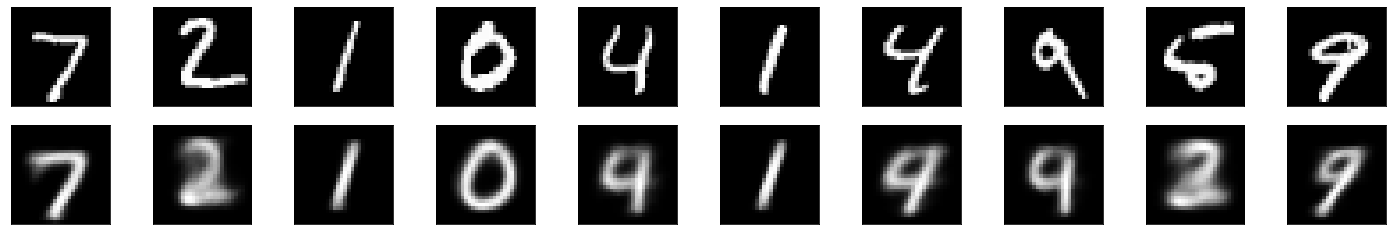

In [10]:
model.cpu()

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

test = images

images_flatten = images.view(images.size(0), -1)
# get sample outputs
mu, log_var, output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
model.cuda()

## Generate completely new data

By choosing a random vector in model's latent space (the autoencoder bottleneck) we can generate new data based on the training set.

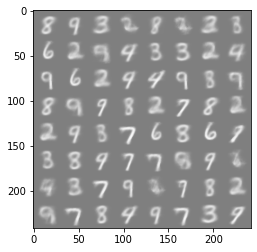

In [11]:
from torchvision.utils import save_image, make_grid
#with torch.no_grad():
z = torch.randn(64, model.hidden_size).cuda()
sample = model.decoder(z).cuda()
sample.view(64, 1, 28, 28)
    
save_image(sample.view(64, 1, 28, 28), 'D:/Gits/MNIST_VAE/notebooks/sample2' + '.png')

sample = sample.cpu()
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(make_grid(sample.view(64, 1, 28, 28)))